In [1]:
a = [0.82026, 0.72222, 0.92137, 0.96032, 0.92633, 0.89818, 0.8815, 0.79216]
b = [0.84571, 0.76636, 0.92893, 0.95041, 0.90091, 0.91505, 0.91349, 0.87451]
import numpy as np
a = np.array(a)
b = np.array(b)
stda = np.std(a)
stdb = np.std(b)
print("std a is: {:.5f}".format(stda), "std b is: {:.5f}".format(stdb)) 
mina = np.min(a)
minb = np.min(b)
print("min a is: {:.5f}".format(mina), "min b is: {:.5f}".format(minb))


std a is: 0.07508 std b is: 0.05463
min a is: 0.72222 min b is: 0.76636


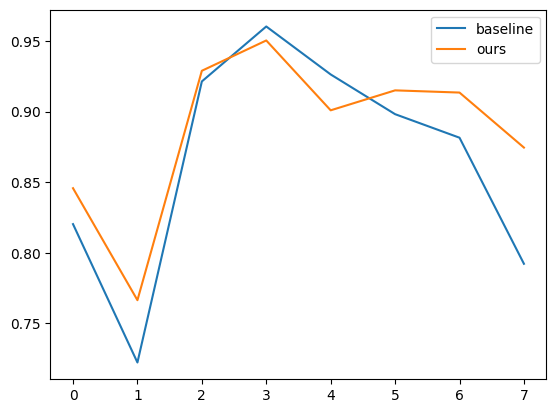

In [2]:
import matplotlib.pyplot as plt 
# show 
plt.plot(a, label='baseline')
plt.plot(b, label='ours')
plt.legend()
plt.show()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
from torch.utils.data import DataLoader, Subset


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=data_transform)


def create_long_tail(dataset, imbalance_ratio=0.02):
    class_counts = np.array([5000 * (imbalance_ratio ** (i / 9.0)) for i in range(10)]).astype(int)
    indices = []
    targets = np.array(dataset.targets)
    for class_idx in range(10):
        class_indices = np.where(targets == class_idx)[0]
        selected_indices = np.random.choice(class_indices, class_counts[class_idx], replace=False)
        indices.extend(selected_indices)
    return Subset(dataset, indices)


long_tail_dataset = create_long_tail(dataset)
dataloader = DataLoader(long_tail_dataset, batch_size=128, shuffle=True, num_workers=4)


test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=data_transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)


model = models.resnet18(pretrained=False, num_classes=100).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
def get_cifar_100_dataset(path='./data/'):
    data_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    dataset = datasets.CIFAR100(root=path, train=True, download=True, transform=data_transform)
    
    
    def create_long_tail(dataset, imbalance_ratio=0.02):
        class_counts = np.array([500 * (imbalance_ratio ** (i / 99.0)) for i in range(100)]).astype(int)
        indices = []
        targets = np.array(dataset.targets)
        for class_idx in range(100):
            class_indices = np.where(targets == class_idx)[0]
            selected_indices = np.random.choice(class_indices, class_counts[class_idx], replace=False)
            indices.extend(selected_indices)
        return Subset(dataset, indices)
    long_tail_dataset = create_long_tail(dataset)
    dataloader = DataLoader(long_tail_dataset, batch_size=128, shuffle=True, num_workers=4)
    test_dataset = datasets.CIFAR100(root=path, train=False, download=True, transform=data_transform)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)
    return dataloader, test_loader


dataloader, test_loader = get_cifar_100_dataset()


def train(model, dataloader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}, Accuracy: {100.*correct/total:.2f}%")
        evaluate(model, test_loader)

def evaluate(model, dataloader, num_class=100):
    model.eval()
    class_correct = torch.zeros(num_class).to(device)
    class_total = torch.zeros(num_class).to(device)
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            for i in range(len(labels)):
                class_total[labels[i]] += 1
                class_correct[labels[i]] += (predicted[i] == labels[i]).item()
    from sklearn.metrics import precision_recall_fscore_support
    prf_macro = precision_recall_fscore_support(y_true, y_pred, average='macro',)
    prf_micro = precision_recall_fscore_support(y_true, y_pred, average='micro')
    prf_weighted = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    print(f"Macro Precision: {prf_macro[0]:.4f}, Recall: {prf_macro[1]:.4f}, F1-Score: {prf_macro[2]:.4f}")
    print(f"Micro Precision: {prf_micro[0]:.4f}, Recall: {prf_micro[1]:.4f}, F1-Score: {prf_micro[2]:.4f}")
    print(f"Weighted Precision: {prf_weighted[0]:.4f}, Recall: {prf_weighted[1]:.4f}, F1-Score: {prf_weighted[2]:.4f}")
    acc_weighted = sum(class_correct) / sum(class_total)
    print(f"Weighted Accuracy: {acc_weighted:.4f}")
    
    print("Class-wise Accuracy:", class_correct / class_total)
    print("variance of accuracy", torch.var(class_correct / class_total))
    print("min accuracy", torch.min(class_correct / class_total))   





In [ ]:
train(model, dataloader, criterion, optimizer, epochs=30)

In [2]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F
class LoraLinear(nn.Module):
    def __init__(self, base_layer, num_class, rank=8, alpha=16, top_k=1):
        super().__init__()
        self.base_layer = base_layer
        self.num_class = num_class
        self.rank = rank
        self.alpha = alpha
        self.top_k = top_k
        
        
        # Freeze original parameters
        for param in base_layer.parameters():
            param.requires_grad = False

        # Add LoRA parameters
        in_features = base_layer.in_features
        out_features = base_layer.out_features
        
        self.lora_A = nn.Parameter(torch.empty((num_class * rank, in_features)))
        self.lora_B = nn.Parameter(torch.zeros((out_features, num_class * rank)))
        self.scaling = alpha / rank
        
        # Initialize LoRA weights
        nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
        
        # Preserve original layer's attributes
        self.bias = base_layer.bias
        
        
    def _topk_lora(self, pseduo_index):
        '''
        Args:
            pseduo_index: [batch_size, num_class]
        '''
        topk_value, topk_index = torch.topk(pseduo_index, self.top_k, dim=1)
        # duplicate from batch_size, num_class to batch_size, num_class * rank
        top_index = topk_index.unsqueeze(2).expand(-1, -1, self.rank)  # [batch_size, num_class, rank]
        top_index = top_index.reshape(-1)  # [batch_size * num_class * rank]
        
        return top_index
        

    def forward(self, x, pseudo_index=None):
        if pseudo_index == None:  # in the first round, only run the base layer and get the pseudo index 
            return self.base_layer(x)
            
        else:  # if run with the no_grad, then only run the base layer
            orig_output = self.base_layer(x)  
            top_index = self._topk_lora(pseudo_index)
            
            # Retrieve and reshape LoRA parameters
            A = self.lora_A[top_index]  # (batch_size * top_k * rank, in_features)
            A = A.view(-1, self.top_k * self.rank, A.size(-1))  # (batch_size, top_k * rank, in_features)
            
            B = self.lora_B[:, top_index]  # (out_features, batch_size * top_k * rank)
            B = B.view(B.size(0), -1, self.top_k * self.rank)  # (out_features, batch_size, top_k * rank)
            B = B.permute(1, 0, 2)  # (batch_size, out_features, top_k * rank)
            
            # Compute delta weights for each sample in the batch
            delta_W = torch.bmm(B, A)  # (batch_size, out_features, in_features)
            
            # Apply LoRA adjustments
            lora_output = (x.unsqueeze(1) @ delta_W.transpose(1, 2)).squeeze(1) * self.scaling
            final_output = orig_output + lora_output
            return final_output + (self.bias if self.bias is not None else 0)

In [8]:
# batch = 10, num_class = 10, in_features = 512, out_features = 512
fc = nn.Linear(512, 10)
lora_linear = LoraLinear(fc, num_class=10, rank=8, alpha=16, top_k=2)
pseudo_index = torch.randint(0, 10, (10, 10))
x = torch.randn(10, 512)
output = lora_linear(x, None)


In [3]:
class RouteLinear(nn.Module):
    def __init__(self, linear_layer, num_classes):
        super(RouteLinear, self).__init__()
        self.linear_layer_weight = linear_layer.weight
        self.linear_layer_weight.requires_grad = False
        self.linear_layer_bias = linear_layer.bias
        self.linear_layer_bias.requires_grad = False
        self.u = torch.nn.Parameter(torch.randn(num_classes, linear_layer.weight.size(1)))
        self.v = torch.nn.Parameter(torch.randn(num_classes, linear_layer.weight.size(0)))
        
        self.attention_route = nn.Linear(linear_layer.weight.size(1), num_classes)
        
        
    def forward(self, x):
        attention = torch.sigmoid(self.attention_route(x))
        # choose top 1 class of the attention
        lora_weight = torch.matmul(attention, self.u).T @ torch.matmul(self.v, self.linear_layer_weight)
        return F.linear(x, lora_weight + self.linear_layer_weight, self.linear_layer_bias)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
from torch.utils.data import DataLoader, Subset


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")






class LoRAResNet18(nn.Module):
    def __init__(self, num_classes=100, base_model=models.resnet18(pretrained=False)):
        super(LoRAResNet18, self).__init__()
        self.resnet = base_model
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        self.attention = nn.Linear(
            self.resnet.fc.in_features, num_classes
        ) 
        self.lora_ranks = nn.ParameterList(
            [
                nn.Parameter(torch.randn(2, self.resnet.fc.in_features))
                for _ in range(num_classes)
            ]
        )

    def forward(self, x):
        features = self.resnet.avgpool(
            self.resnet.layer4(
                self.resnet.layer3(
                    self.resnet.layer2(self.resnet.layer1(self.resnet.conv1(x)))
                )
            )
        )
        features = torch.flatten(features, 1)
        attn_weights = self.attention(features)
        top1_class = torch.argmax(attn_weights, dim=1)
        selected_lora = torch.stack([self.lora_ranks[i] for i in top1_class])
        print(selected_lora.shape)
        adapted_features = features + selected_lora.squeeze(1)  # 应用选择的 LoRA
        out = self.resnet.fc(adapted_features)
        return out


model = LoRAResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train(model, dataloader, criterion, optimizer, epochs=50):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        print(
            f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}, Accuracy: {100.*correct/total:.2f}%"
        )
        evaluate(model, test_loader)



# def evaluate(model, dataloader):
#     model.eval()
#     class_correct = torch.zeros(10).to(device)
#     class_total = torch.zeros(10).to(device)
#     with torch.no_grad():
#         for images, labels in dataloader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             _, predicted = torch.max(outputs, 1)
#             for i in range(len(labels)):
#                 class_total[labels[i]] += 1
#                 class_correct[labels[i]] += (predicted[i] == labels[i]).item()

#     for i in range(10):
#         acc = 100.0 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
#         print(f"Class {i}: Accuracy: {acc:.2f}%")



train(model, dataloader, criterion, optimizer, epochs=50)

/Users/dingzhu/miniconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/dingzhu/miniconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([128, 2, 512])


RuntimeError: The size of tensor a (128) must match the size of tensor b (2) at non-singleton dimension 1

In [ ]:
Epoch 4/30, Loss: 0.7453, Accuracy: 74.34%
Macro Precision: 0.5751, Recall: 0.4322, F1-Score: 0.3747
Micro Precision: 0.4322, Recall: 0.4322, F1-Score: 0.4322
Weighted Precision: 0.5751, Recall: 0.4322, F1-Score: 0.3747
Weighted Accuracy: 0.4322
Class-wise Accuracy: tensor([0.8950, 0.9300, 0.6820, 0.3760, 0.1070, 0.4610, 0.4400, 0.3430, 0.0450,
        0.0430], device='cuda:0')
Epoch 5/30, Loss: 0.6793, Accuracy: 76.68%
Macro Precision: 0.6045, Recall: 0.4439, F1-Score: 0.4009
Micro Precision: 0.4439, Recall: 0.4439, F1-Score: 0.4439
Weighted Precision: 0.6045, Recall: 0.4439, F1-Score: 0.4009
Weighted Accuracy: 0.4439
Class-wise Accuracy: tensor([0.8290, 0.8830, 0.8120, 0.4040, 0.4310, 0.2420, 0.4550, 0.2370, 0.1290,
        0.0170], device='cuda:0')
Epoch 6/30, Loss: 0.6101, Accuracy: 79.41%
Macro Precision: 0.5820, Recall: 0.4625, F1-Score: 0.4160
Micro Precision: 0.4625, Recall: 0.4625, F1-Score: 0.4625
Weighted Precision: 0.5820, Recall: 0.4625, F1-Score: 0.4160
Weighted Accuracy: 0.4625
Class-wise Accuracy: tensor([0.8700, 0.8740, 0.6770, 0.5110, 0.3940, 0.3770, 0.5610, 0.2020, 0.1460,
        0.0130], device='cuda:0')
Epoch 7/30, Loss: 0.5579, Accuracy: 80.45%
Macro Precision: 0.6133, Recall: 0.5089, F1-Score: 0.4707
Micro Precision: 0.5089, Recall: 0.5089, F1-Score: 0.5089
Weighted Precision: 0.6133, Recall: 0.5089, F1-Score: 0.4707
Weighted Accuracy: 0.5089
Class-wise Accuracy: tensor([0.8480, 0.9140, 0.6070, 0.5200, 0.7150, 0.2790, 0.4620, 0.5040, 0.2140,
        0.0260], device='cuda:0')
Epoch 8/30, Loss: 0.5040, Accuracy: 82.44%
Macro Precision: 0.6165, Recall: 0.4662, F1-Score: 0.4280
Micro Precision: 0.4662, Recall: 0.4662, F1-Score: 0.4662
Weighted Precision: 0.6165, Recall: 0.4662, F1-Score: 0.4280
Weighted Accuracy: 0.4662
Class-wise Accuracy: tensor([0.9340, 0.9040, 0.6580, 0.5340, 0.4370, 0.3580, 0.2260, 0.3820, 0.1870,
        0.0420], device='cuda:0')
Epoch 9/30, Loss: 0.4566, Accuracy: 84.17%
Macro Precision: 0.6290, Recall: 0.4820, F1-Score: 0.4497
Micro Precision: 0.4820, Recall: 0.4820, F1-Score: 0.4820
Weighted Precision: 0.6290, Recall: 0.4820, F1-Score: 0.4497
Weighted Accuracy: 0.4820
Class-wise Accuracy: tensor([0.9040, 0.9380, 0.7320, 0.4650, 0.4630, 0.2480, 0.4000, 0.4030, 0.1540,
        0.1130], device='cuda:0')
Epoch 10/30, Loss: 0.4185, Accuracy: 85.35%
Macro Precision: 0.6339, Recall: 0.5085, F1-Score: 0.4864
Micro Precision: 0.5085, Recall: 0.5085, F1-Score: 0.5085
Weighted Precision: 0.6339, Recall: 0.5085, F1-Score: 0.4864
Weighted Accuracy: 0.5085
Class-wise Accuracy: tensor([0.9440, 0.8800, 0.5900, 0.5790, 0.4900, 0.3420, 0.3900, 0.5410, 0.1520,
        0.1770], device='cuda:0')
Epoch 11/30, Loss: 0.3723, Accuracy: 87.26%
Macro Precision: 0.6435, Recall: 0.5196, F1-Score: 0.4932
Micro Precision: 0.5196, Recall: 0.5196, F1-Score: 0.5196
Weighted Precision: 0.6435, Recall: 0.5196, F1-Score: 0.4932
Weighted Accuracy: 0.5196
Class-wise Accuracy: tensor([0.9070, 0.9270, 0.6130, 0.6220, 0.4460, 0.3630, 0.4780, 0.5020, 0.2800,
        0.0580], device='cuda:0')
Epoch 12/30, Loss: 0.3377, Accuracy: 88.35%
Macro Precision: 0.6353, Recall: 0.5376, F1-Score: 0.5102
Micro Precision: 0.5376, Recall: 0.5376, F1-Score: 0.5376
Weighted Precision: 0.6353, Recall: 0.5376, F1-Score: 0.5102
Weighted Accuracy: 0.5376
Class-wise Accuracy: tensor([0.9160, 0.9050, 0.5760, 0.6740, 0.5190, 0.2970, 0.6690, 0.3810, 0.3810,
        0.0580], device='cuda:0')
Epoch 13/30, Loss: 0.3001, Accuracy: 89.56%
Macro Precision: 0.6328, Recall: 0.4982, F1-Score: 0.4685
Micro Precision: 0.4982, Recall: 0.4982, F1-Score: 0.4982
Weighted Precision: 0.6328, Recall: 0.4982, F1-Score: 0.4685
Weighted Accuracy: 0.4982
Class-wise Accuracy: tensor([0.8910, 0.9080, 0.7480, 0.4930, 0.4890, 0.3050, 0.4500, 0.4150, 0.2100,
        0.0730], device='cuda:0')
Epoch 14/30, Loss: 0.2692, Accuracy: 90.72%
Macro Precision: 0.6275, Recall: 0.4877, F1-Score: 0.4591
Micro Precision: 0.4877, Recall: 0.4877, F1-Score: 0.4877
Weighted Precision: 0.6275, Recall: 0.4877, F1-Score: 0.4591
Weighted Accuracy: 0.4877
Class-wise Accuracy: tensor([0.9260, 0.9120, 0.6780, 0.5550, 0.4520, 0.2170, 0.4430, 0.2860, 0.3260,
        0.0820], device='cuda:0')
Epoch 15/30, Loss: 0.2568, Accuracy: 91.30%
Macro Precision: 0.6411, Recall: 0.5431, F1-Score: 0.5176
Micro Precision: 0.5431, Recall: 0.5431, F1-Score: 0.5431
Weighted Precision: 0.6411, Recall: 0.5431, F1-Score: 0.5176
Weighted Accuracy: 0.5431
Class-wise Accuracy: tensor([0.9130, 0.9210, 0.5730, 0.4630, 0.7130, 0.3650, 0.5980, 0.5310, 0.1600,
        0.1940], device='cuda:0')
Epoch 16/30, Loss: 0.2053, Accuracy: 93.06%
Macro Precision: 0.6384, Recall: 0.5305, F1-Score: 0.5077
Micro Precision: 0.5305, Recall: 0.5305, F1-Score: 0.5305
Weighted Precision: 0.6384, Recall: 0.5305, F1-Score: 0.5077
Weighted Accuracy: 0.5305
Class-wise Accuracy: tensor([0.8620, 0.8890, 0.6830, 0.5930, 0.5960, 0.3580, 0.4810, 0.3820, 0.3700,
        0.0910], device='cuda:0')
Epoch 17/30, Loss: 0.1921, Accuracy: 93.27%
Macro Precision: 0.6370, Recall: 0.5140, F1-Score: 0.4889
Micro Precision: 0.5140, Recall: 0.5140, F1-Score: 0.5140
Weighted Precision: 0.6370, Recall: 0.5140, F1-Score: 0.4889
Weighted Accuracy: 0.5140
Class-wise Accuracy: tensor([0.8790, 0.9150, 0.7310, 0.6530, 0.3350, 0.3270, 0.4450, 0.4070, 0.3690,
        0.0790], device='cuda:0')
Epoch 18/30, Loss: 0.1683, Accuracy: 93.97%
Macro Precision: 0.6389, Recall: 0.5362, F1-Score: 0.5168
Micro Precision: 0.5362, Recall: 0.5362, F1-Score: 0.5362
Weighted Precision: 0.6389, Recall: 0.5362, F1-Score: 0.5168
Weighted Accuracy: 0.5362
Class-wise Accuracy: tensor([0.9180, 0.9080, 0.6990, 0.5390, 0.4990, 0.2900, 0.5550, 0.4990, 0.3130,
        0.1420], device='cuda:0')
Epoch 19/30, Loss: 0.1580, Accuracy: 94.59%
Macro Precision: 0.6408, Recall: 0.5280, F1-Score: 0.5042
Micro Precision: 0.5280, Recall: 0.5280, F1-Score: 0.5280
Weighted Precision: 0.6408, Recall: 0.5280, F1-Score: 0.5042
Weighted Accuracy: 0.5280
Class-wise Accuracy: tensor([0.9360, 0.9020, 0.6380, 0.5560, 0.5350, 0.4030, 0.4770, 0.4830, 0.2700,
        0.0800], device='cuda:0')
Epoch 20/30, Loss: 0.1524, Accuracy: 94.63%
Macro Precision: 0.6315, Recall: 0.5384, F1-Score: 0.5196
Micro Precision: 0.5384, Recall: 0.5384, F1-Score: 0.5384
Weighted Precision: 0.6315, Recall: 0.5384, F1-Score: 0.5196
Weighted Accuracy: 0.5384
Class-wise Accuracy: tensor([0.8870, 0.8770, 0.6910, 0.4950, 0.6350, 0.4050, 0.4030, 0.5420, 0.2930,
        0.1560], device='cuda:0')
Epoch 21/30, Loss: 0.1285, Accuracy: 95.59%
Macro Precision: 0.6451, Recall: 0.5522, F1-Score: 0.5384
Micro Precision: 0.5522, Recall: 0.5522, F1-Score: 0.5522
Weighted Precision: 0.6451, Recall: 0.5522, F1-Score: 0.5384
Weighted Accuracy: 0.5522
Class-wise Accuracy: tensor([0.8820, 0.9110, 0.7170, 0.5270, 0.5400, 0.4720, 0.5080, 0.4400, 0.2800,
        0.2450], device='cuda:0')
Epoch 22/30, Loss: 0.1228, Accuracy: 95.93%
Macro Precision: 0.6451, Recall: 0.5332, F1-Score: 0.5072
Micro Precision: 0.5332, Recall: 0.5332, F1-Score: 0.5332
Weighted Precision: 0.6451, Recall: 0.5332, F1-Score: 0.5072
Weighted Accuracy: 0.5332
Class-wise Accuracy: tensor([0.9110, 0.9210, 0.7070, 0.5130, 0.5290, 0.4310, 0.5590, 0.4200, 0.2500,
        0.0910], device='cuda:0')
Epoch 23/30, Loss: 0.1146, Accuracy: 95.98%
Macro Precision: 0.6333, Recall: 0.5331, F1-Score: 0.5089
Micro Precision: 0.5331, Recall: 0.5331, F1-Score: 0.5331
Weighted Precision: 0.6333, Recall: 0.5331, F1-Score: 0.5089
Weighted Accuracy: 0.5331
Class-wise Accuracy: tensor([0.9020, 0.9250, 0.5930, 0.6210, 0.6040, 0.4090, 0.5470, 0.3760, 0.1640,
        0.1900], device='cuda:0')
Epoch 24/30, Loss: 0.1063, Accuracy: 96.34%
Macro Precision: 0.6455, Recall: 0.5532, F1-Score: 0.5348
Micro Precision: 0.5532, Recall: 0.5532, F1-Score: 0.5532
Weighted Precision: 0.6455, Recall: 0.5532, F1-Score: 0.5348
Weighted Accuracy: 0.5532
Class-wise Accuracy: tensor([0.9080, 0.9270, 0.6180, 0.5170, 0.6480, 0.4630, 0.4420, 0.5310, 0.3030,
        0.1750], device='cuda:0')
Epoch 25/30, Loss: 0.1070, Accuracy: 96.53%
Macro Precision: 0.6504, Recall: 0.5468, F1-Score: 0.5316
Micro Precision: 0.5468, Recall: 0.5468, F1-Score: 0.5468
Weighted Precision: 0.6504, Recall: 0.5468, F1-Score: 0.5316
Weighted Accuracy: 0.5468
Class-wise Accuracy: tensor([0.8950, 0.8970, 0.5930, 0.6200, 0.6150, 0.4370, 0.4930, 0.4240, 0.3380,
        0.1560], device='cuda:0')
Epoch 26/30, Loss: 0.1138, Accuracy: 96.05%
Macro Precision: 0.6402, Recall: 0.5368, F1-Score: 0.5022
Micro Precision: 0.5368, Recall: 0.5368, F1-Score: 0.5368
Weighted Precision: 0.6402, Recall: 0.5368, F1-Score: 0.5022
Weighted Accuracy: 0.5368
Class-wise Accuracy: tensor([0.8900, 0.9450, 0.6740, 0.4830, 0.6890, 0.4200, 0.5790, 0.4280, 0.1630,
        0.0970], device='cuda:0')
Epoch 27/30, Loss: 0.0778, Accuracy: 97.48%
Macro Precision: 0.6558, Recall: 0.5489, F1-Score: 0.5306
Micro Precision: 0.5489, Recall: 0.5489, F1-Score: 0.5489
Weighted Precision: 0.6558, Recall: 0.5489, F1-Score: 0.5306
Weighted Accuracy: 0.5489
Class-wise Accuracy: tensor([0.9140, 0.9330, 0.5890, 0.6580, 0.6000, 0.3560, 0.5240, 0.4630, 0.2970,
        0.1550], device='cuda:0')
Epoch 28/30, Loss: 0.0771, Accuracy: 97.26%
Macro Precision: 0.6608, Recall: 0.5482, F1-Score: 0.5263
Micro Precision: 0.5482, Recall: 0.5482, F1-Score: 0.5482
Weighted Precision: 0.6608, Recall: 0.5482, F1-Score: 0.5263
Weighted Accuracy: 0.5482
Class-wise Accuracy: tensor([0.9190, 0.9250, 0.6490, 0.6380, 0.5050, 0.4480, 0.5770, 0.4430, 0.2530,
        0.1250], device='cuda:0')
Epoch 29/30, Loss: 0.0863, Accuracy: 96.90%
Macro Precision: 0.6357, Recall: 0.5346, F1-Score: 0.5086
Micro Precision: 0.5346, Recall: 0.5346, F1-Score: 0.5346
Weighted Precision: 0.6357, Recall: 0.5346, F1-Score: 0.5086
Weighted Accuracy: 0.5346
Class-wise Accuracy: tensor([0.9020, 0.9460, 0.6810, 0.6010, 0.5020, 0.3060, 0.5200, 0.4860, 0.3120,
        0.0900], device='cuda:0')
Epoch 30/30, Loss: 0.0593, Accuracy: 97.98%
Macro Precision: 0.6482, Recall: 0.5529, F1-Score: 0.5337
Micro Precision: 0.5529, Recall: 0.5529, F1-Score: 0.5529
Weighted Precision: 0.6482, Recall: 0.5529, F1-Score: 0.5337
Weighted Accuracy: 0.5529
Class-wise Accuracy: tensor([0.8800, 0.9390, 0.7200, 0.5820, 0.5650, 0.3810, 0.5350, 0.4790, 0.2820,
        0.1660], device='cuda:0')

# CIFAR 10 dataset

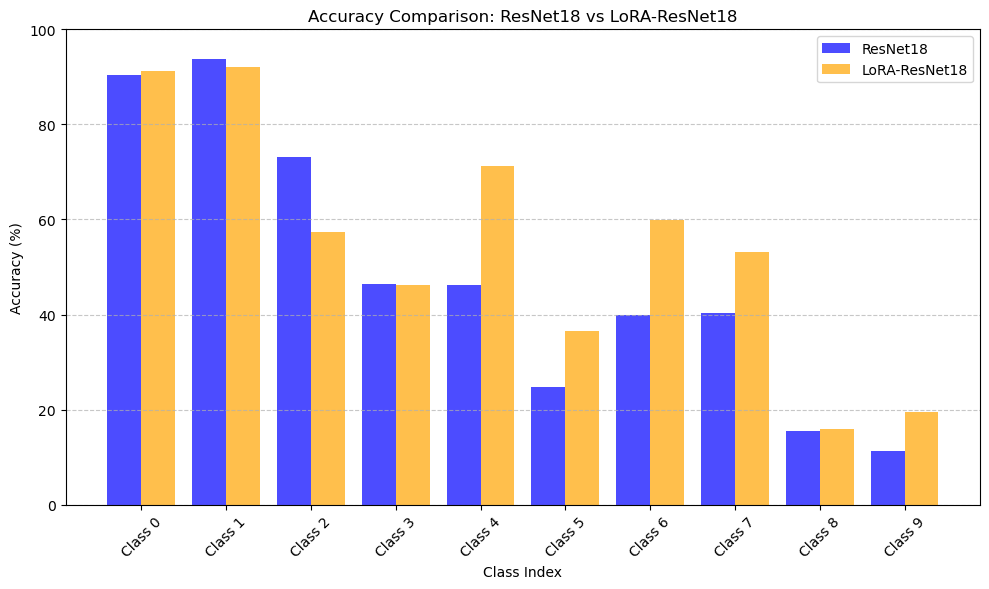

variance of our accuracy tensor(688.1410, dtype=torch.float64)
variance of resnet accuracy tensor(845.1511, dtype=torch.float64)
min accuracy of our model tensor(16., dtype=torch.float64)
min accuracy of resnet model tensor(11.3000, dtype=torch.float64)


In [6]:
a = [89.1, 91.2, 75.5, 52.5, 43.5, 43.1, 37.1, 29.6, 5.9]
b = [90.1, 86.4, 74.0, 50.5, 43.4, 34.9, 49.6, 44, 15.5, 23.1]
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import torch

# Accuracy values for each class
a = [0.9040, 0.9380, 0.7320, 0.4650, 0.4630, 0.2480, 0.4000, 0.4030, 0.1540,
        0.1130]
b = [0.9130, 0.9210, 0.5730, 0.4630, 0.7130, 0.3650, 0.5980, 0.5310, 0.1600,
        0.1940]
a = np.array(a) * 100
b = np.array(b) * 100
# a = [89.1, 91.2, 75.5, 52.5, 43.5, 43.1, 37.1, 29.6, 5.9]
# b = [90.1, 86.4, 74.0, 50.5, 43.4, 34.9, 49.6, 44, 15.5]

# Number of classes
num_classes = len(a)
indices = np.arange(num_classes)
width = 0.4  # Width of bars

plt.figure(figsize=(10, 6))
plt.bar(indices - width/2, a, width, label='ResNet18', color='blue', alpha=0.7)
plt.bar(indices + width/2, b, width, label='LoRA-ResNet18', color='orange', alpha=0.7)

plt.xlabel('Class Index')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison: ResNet18 vs LoRA-ResNet18')
plt.xticks(indices, [f'Class {i}' for i in range(num_classes)], rotation=45)
plt.ylim(0, 100)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("variance of our accuracy", torch.var(torch.tensor(b)))
print("variance of resnet accuracy", torch.var(torch.tensor(a)))
print("min accuracy of our model", torch.min(torch.tensor(b)))
print("min accuracy of resnet model", torch.min(torch.tensor(a)))



# Conll03 Dataset

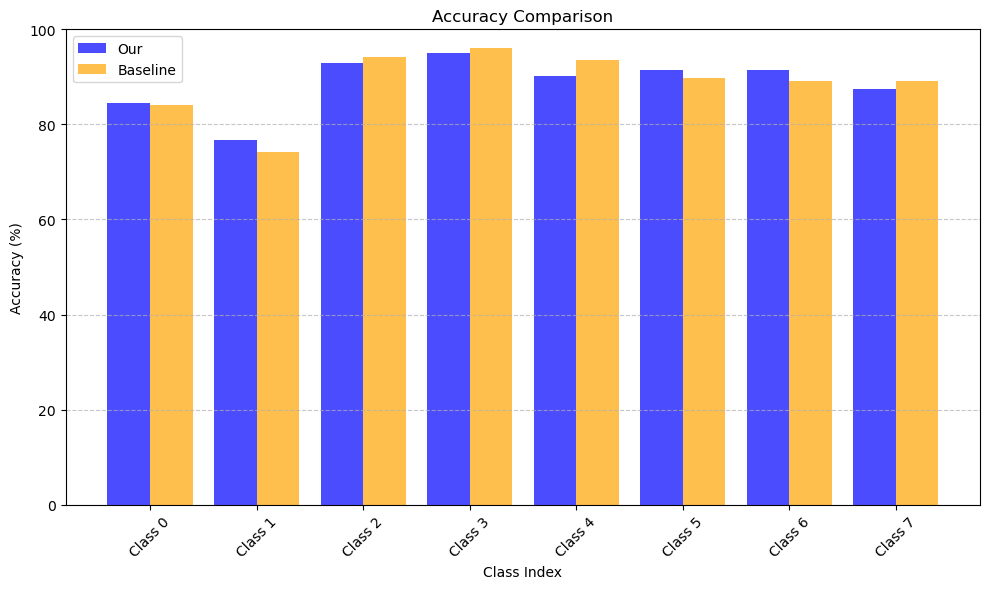

overall accuracy of our method:  88.692125
overall accuracy of baseline:  88.77924999999999
variance of our method:  29.844734859374974
variance of baseline:  42.59760968750002
min value of our method:  76.63600000000001
min value of baseline:  74.222


In [12]:
ours_results = [ 0.84571, 0.76636, 0.92893, 0.95041, 0.90091, 0.91505,
                0.91349, 0.87451]
# baseline results:
# wandb:    token/test-class-1-accuracy 0.82026
# wandb:    token/test-class-2-accuracy 0.72222
# wandb:    token/test-class-3-accuracy 0.92137
# wandb:    token/test-class-4-accuracy 0.96032
# wandb:    token/test-class-5-accuracy 0.92633
# wandb:    token/test-class-6-accuracy 0.89818
# wandb:    token/test-class-7-accuracy 0.8815
# wandb:    token/test-class-8-accuracy 0.79216
baseline_results = [0.84026, 0.74222, 0.94137, 0.96032, 0.93633,
                    0.89818, 0.8915, 0.89216]
import numpy as np
import matplotlib.pyplot as plt
a = np.array(ours_results) * 100
b = np.array(baseline_results) * 100
num_classes = len(a)
indices = np.arange(num_classes)
width = 0.4  # Width of bars

plt.figure(figsize=(10, 6))
plt.bar(indices - width/2, a, width, label='Our', color='blue', alpha=0.7)
plt.bar(indices + width/2, b, width, label='Baseline', color='orange', alpha=0.7)

plt.xlabel('Class Index')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison')
plt.xticks(indices, [f'Class {i}' for i in range(num_classes)], rotation=45)
plt.ylim(0, 100)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("overall accuracy of our method: ", np.mean(a))
print("overall accuracy of baseline: ", np.mean(b))

print("variance of our method: ", np.var(a))
print("variance of baseline: ", np.var(b))
print("min value of our method: ", np.min(a))
print("min value of baseline: ", np.min(b))

# JNL NER results 

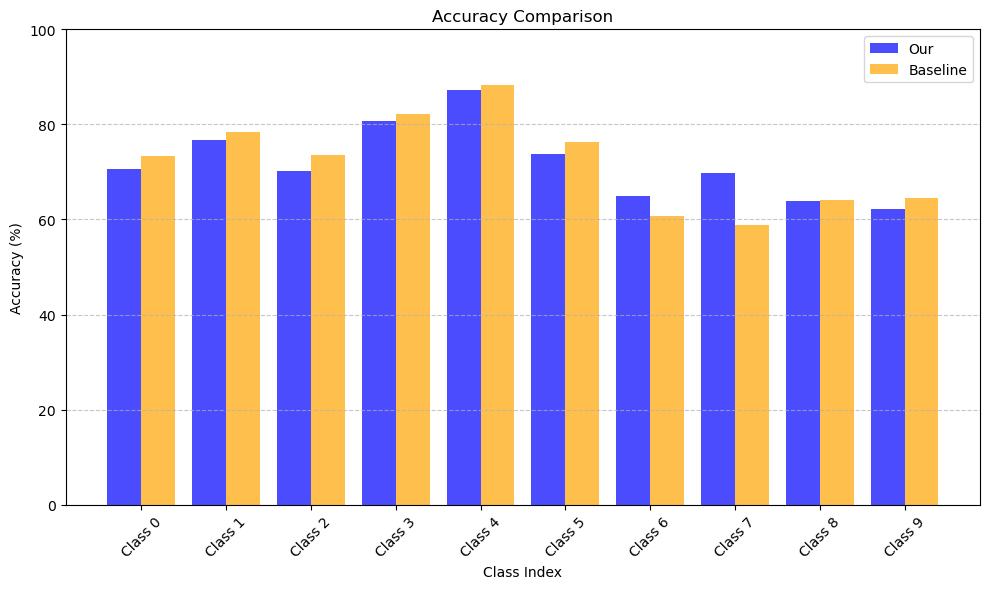

mean of our method:  0.71984
mean of baseline:  0.7199500000000001
variance of our method:  0.005517942399999999
variance of baseline:  0.0085267365
min value of our method:  0.6228
min value of baseline:  0.5879


In [21]:

ours_acc= [0.7072, 0.7672, 0.7009, 0.8065, 0.8718,
        0.7373, 0.6487, 0.6968, 0.6392, 0.6228]
baseline_acc = [
    0.7330, 0.7831, 0.7350, 0.8219, 0.8830,
    0.7629, 0.6075, 0.5879, 0.6403, 0.6449
]
import numpy as np
import matplotlib.pyplot as plt
a = np.array(ours_acc) * 100
b = np.array(baseline_acc) * 100
num_classes = len(a)
indices = np.arange(num_classes)
width = 0.4  # Width of bars

plt.figure(figsize=(10, 6))
plt.bar(indices - width/2, a, width, label='Our', color='blue', alpha=0.7)
plt.bar(indices + width/2, b, width, label='Baseline', color='orange', alpha=0.7)

plt.xlabel('Class Index')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison')
plt.xticks(indices, [f'Class {i}' for i in range(num_classes)], rotation=45)
plt.ylim(0, 100)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("mean of our method: ", np.mean(ours_acc))
print("mean of baseline: ", np.mean(baseline_acc))
print("variance of our method: ", np.var(ours_acc))
print("variance of baseline: ", np.var(baseline_acc))
print("min value of our method: ", np.min(ours_acc))
print("min value of baseline: ", np.min(baseline_acc))

# CIAFR-100 Results 

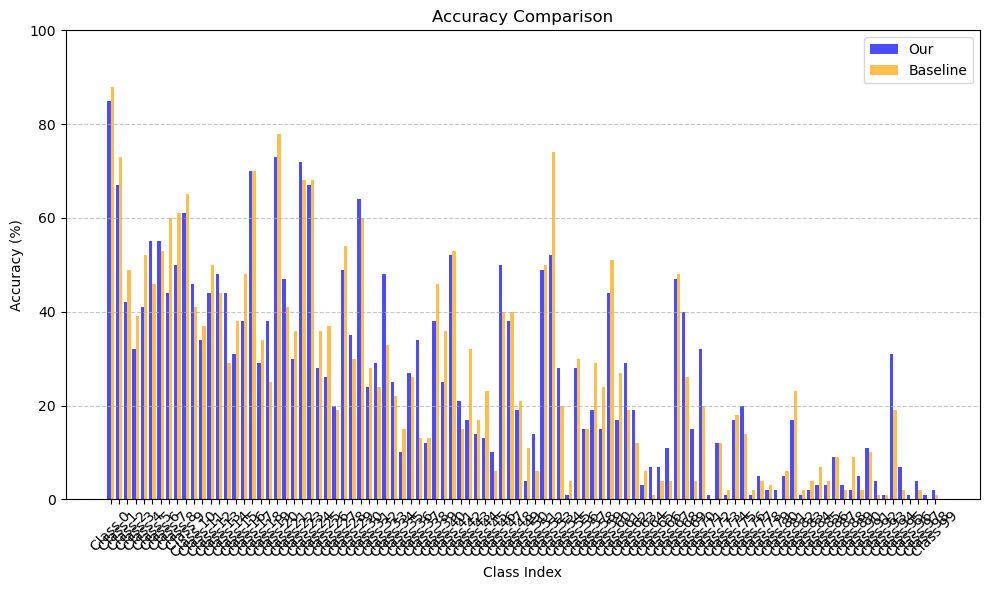

weighted accuracy of our method: 98.95
weighted accuracy of baseline: 95.92
variance of our method:  430.78000000000014
variance of baseline:  485.8424
min value of our method:  0.01
min value of baseline:  0.0
average acc of our method 26.4
average acc of baseline 26.76


In [23]:
baseline_results = [0.8800, 0.7300, 0.4900, 0.3900, 0.5200, 0.4600, 0.5300, 0.6000, 0.6100,
        0.6500, 0.4100, 0.3700, 0.5000, 0.4400, 0.2900, 0.3800, 0.4800, 0.7000,
        0.3400, 0.2500, 0.7800, 0.4100, 0.3600, 0.6800, 0.6800, 0.3600, 0.3700,
        0.1900, 0.5400, 0.3000, 0.6000, 0.2800, 0.2400, 0.3300, 0.2200, 0.1500,
        0.2600, 0.1300, 0.1300, 0.4600, 0.3600, 0.5300, 0.1500, 0.3200, 0.1700,
        0.2300, 0.0600, 0.4000, 0.4000, 0.2100, 0.1100, 0.0600, 0.5000, 0.7400,
        0.2000, 0.0400, 0.3000, 0.1500, 0.2900, 0.2400, 0.5100, 0.2700, 0.1900,
        0.1200, 0.0600, 0.0100, 0.0400, 0.0400, 0.4800, 0.2600, 0.0400, 0.2000,
        0.0000, 0.1200, 0.0200, 0.1800, 0.1400, 0.0200, 0.0400, 0.0300, 0.0000,
        0.0600, 0.2300, 0.0200, 0.0400, 0.0700, 0.0400, 0.0900, 0.0200, 0.0900,
        0.0200, 0.1000, 0.0100, 0.0100, 0.1900, 0.0200, 0.0000, 0.0200, 0.0000,
        0.0100]
ours_results = [0.8500, 0.6700, 0.4200, 0.3200, 0.4100, 0.5500, 0.5500, 0.4400, 0.5000,
        0.6100, 0.4600, 0.3400, 0.4400, 0.4800, 0.4400, 0.3100, 0.3800, 0.7000,
        0.2900, 0.3800, 0.7300, 0.4700, 0.3000, 0.7200, 0.6700, 0.2800, 0.2600,
        0.2000, 0.4900, 0.3500, 0.6400, 0.2400, 0.2900, 0.4800, 0.2500, 0.1000,
        0.2700, 0.3400, 0.1200, 0.3800, 0.2500, 0.5200, 0.2100, 0.1700, 0.1400,
        0.1300, 0.1000, 0.5000, 0.3800, 0.1900, 0.0400, 0.1400, 0.4900, 0.5200,
        0.2800, 0.0100, 0.2800, 0.1500, 0.1900, 0.1500, 0.4400, 0.1700, 0.2900,
        0.1900, 0.0300, 0.0700, 0.0700, 0.1100, 0.4700, 0.4000, 0.1500, 0.3200,
        0.0100, 0.1200, 0.0100, 0.1700, 0.2000, 0.0100, 0.0500, 0.0200, 0.0200,
        0.0500, 0.1700, 0.0100, 0.0200, 0.0300, 0.0300, 0.0900, 0.0300, 0.0200,
        0.0500, 0.1100, 0.0400, 0.0100, 0.3100, 0.0700, 0.0100, 0.0400, 0.0100,
        0.0200]

import numpy as np
import matplotlib.pyplot as plt
a = np.array(ours_results) * 100
b = np.array(baseline_results) * 100
num_classes = len(a)
indices = np.arange(num_classes)
width = 0.4  # Width of bars

plt.figure(figsize=(10, 6))
plt.bar(indices - width/2, a, width, label='Our', color='blue', alpha=0.7)
plt.bar(indices + width/2, b, width, label='Baseline', color='orange', alpha=0.7)

plt.xlabel('Class Index')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison')
plt.xticks(indices, [f'Class {i}' for i in range(num_classes)], rotation=45)
plt.ylim(0, 100)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


print("weighted accuracy of our method:", 98.95)
print("weighted accuracy of baseline:", 95.92)
print("variance of our method: ", np.var(a))
print("variance of baseline: ", np.var(b))
print("min value of our method: ", np.min(a) * 0.01)
print("min value of baseline: ", np.min(b) * 0.01)
print("average acc of our method", np.mean(a))
print("average acc of baseline", np.mean(b))
